In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
# reading in data from the first protein
protein_name = "P06576"
df = pd.read_csv(f"data/AF-{protein_name}-F1-model_v3.tsv", sep='\t')
df

,index,x,y,z,gamma,exp,obs
0,1,-42.837,23.391,-21.941,0.745440,0.478957,1
1,2,-44.378,23.992,-19.200,0.731867,0.600007,1
2,3,-43.666,26.752,-16.588,0.800735,0.629776,0
3,4,-45.496,28.227,-13.523,0.859532,0.626594,1
4,5,-45.188,31.063,-11.276,0.952902,0.618848,2
...,...,...,...,...,...,...,...
524,525,-25.544,13.985,35.053,0.415150,0.539781,0
525,526,-25.842,16.957,32.577,0.746953,0.543265,0
526,527,-29.678,16.403,32.433,0.803300,0.551986,0
527,528,-29.901,16.219,36.291,0.823836,0.508357,1


In [3]:
# Takes an array of values and returns a 2d array of 
def subsegment_variances(A):
    # print(A)
    N = len(A)
    vars = np.zeros(shape=(N, N))
    means = np.zeros(shape=(N, N))
    for start in range(N):
        n, mu, var = 0, 0, 0
        for end in range(start, N):
            # print(n, mu, var)
            dmu = (A[end] - mu) / (n+1)
            nmu = mu + dmu
            nvar = 1/(n + (n == 0)) * ((n-1)*var + n*dmu**2 + (A[end] - nmu)**2)
            n, mu, var = n+1, nmu, nvar

            vars[start][end] = var
            means[start][end] = mu

    return vars, means


# subsegment_variances(np.array(range(5)))

In [4]:


x_vars, _ = subsegment_variances(df.x)
y_vars, _ = subsegment_variances(df.y)
z_vars, _ = subsegment_variances(df.z)
_, obs_means = subsegment_variances(df.obs)


N = len(df)
ONE = np.ones((N, 1))

cum_obs = df.obs.values.cumsum().reshape((-1, 1))
subseq_obs = np.maximum((ONE @ cum_obs.T - cum_obs @ ONE.T), 0)

cum_exp = df.exp.values.cumsum().reshape((-1, 1))
subseq_exp = np.maximum((ONE @ cum_exp.T - cum_exp @ ONE.T), 0.0001)

gamma = subseq_obs/subseq_exp

# generate pairwise distances
N = len(df)
dists = np.zeros(shape=(N, N))
for a in range(N):
    for b in range(a, N):
        dists[a][b] = (df.x[a]-df.x[b])**2 + (df.y[a]-df.y[b])**2 + (df.z[a]-df.z[b])**2

# np.maximum((cum_obs @ ONE.T), 0).shape

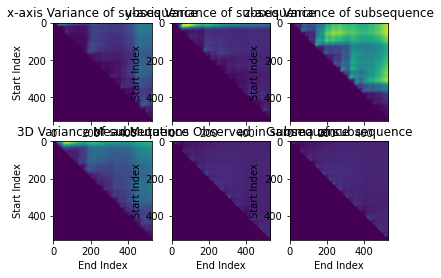

In [5]:
plt.rcParams['figure.figsize'] = [20, 10]


domains = [(96, 318), (466,650)]



plt.rcParams['figure.figsize'] = [20, 10]


# plot
# fig, ax = plt.subplots(3, 4)
fig, ax = plt.subplots(2, 3)

ax[0][0].set_title('x-axis Variance of subsequence')
ax[0][0].set_ylabel('Start Index')
ax[0][0].set_xlabel('End Index')
ax[0][0].imshow(x_vars)

ax[0][1].set_title('y-axis Variance of subsequence')
ax[0][1].set_ylabel('Start Index')
ax[0][1].set_xlabel('End Index')
ax[0][1].imshow(y_vars)

ax[0][2].set_title('z-axis Variance of subsequence')
ax[0][2].set_ylabel('Start Index')
ax[0][2].set_xlabel('End Index')
ax[0][2].imshow(z_vars)

ax[1][0].set_title('3D Variance of subsequence')
ax[1][0].set_ylabel('Start Index')
ax[1][0].set_xlabel('End Index')
ax[1][0].imshow(x_vars + y_vars + z_vars)

ax[1][1].set_title('Mean Mutations Observed in subsequence')
ax[1][1].set_ylabel('Start Index')
ax[1][1].set_xlabel('End Index')
ax[1][1].imshow(obs_means)

ax[1][2].set_title('Gamma of subsequence')
ax[1][2].set_ylabel('Start Index')
ax[1][2].set_xlabel('End Index')
ax[1][2].imshow(gamma)
# for i in range(2):
#     for j in range(3):
#         ax[i][j].plot([96, 318, 318, 466, 650, 650], [96, 96, 318, 466, 466, 640])

# ax[2][1].imshow(dists)


plt.show()

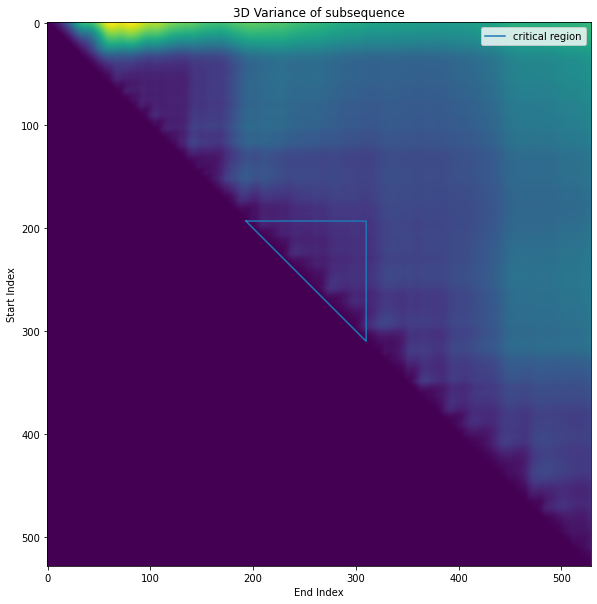

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
var_3d = x_vars + y_vars + z_vars

# since the grid is 50% full of 0s, the 60th percentile corresponds to the 20th percentile of actual data.
perc_10 = np.percentile(var_3d, 60)

IOTA = np.array(range(N)).reshape((-1, 1))
# start_index = IOTA @ ONE.T
# end_index = ONE @ IOTA.T
segment_size = ONE @ IOTA.T - IOTA @ ONE.T
segment_size = np.where(var_3d < perc_10, segment_size, 0)
mx = np.argmax(segment_size)

si, ei = mx // N, mx % N
fig, ax = plt.subplots()
ax.set_title('3D Variance of subsequence')
ax.set_ylabel('Start Index')
ax.set_xlabel('End Index')
plt.imshow(var_3d)
plt.plot([si, ei, ei, si], [si, si, ei, si], label="critical region")
plt.legend()
plt.show()

In [7]:
selection = np.logical_and(IOTA > si, IOTA <= ei).reshape((-1))
selection_gamma = df.obs.values[selection].sum() / df.exp.values[selection].sum()
other_gamma = df.obs.values[np.logical_not(selection)].sum() / df.exp.values[np.logical_not(selection)].sum()

scores = np.where(selection, selection_gamma, other_gamma)
save_colouring(scores, f"data/{protein_name}_proximity_scores.tsv")

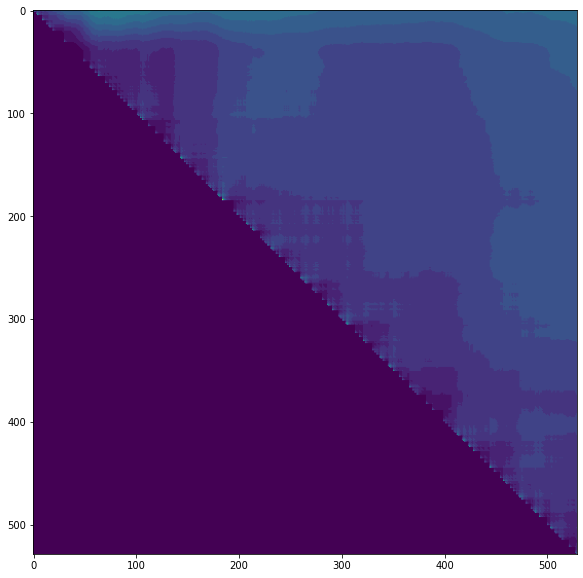

In [8]:
vars = x_vars + y_vars + z_vars
# print(obs_means)sasa
# print(np.around(vars/vars.mean() + obs_means/obs_means.mean(), 1))
wavg = np.around(vars/vars.mean() + obs_means/obs_means.mean())
a = np.array([[max(0, i-j) for i in range(N)] for j in range(N)])
plt.imshow(wavg)

# Final answer is take the longest low-valued region and colour that differently to the rest

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_5856\901226072.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(1/wavg)


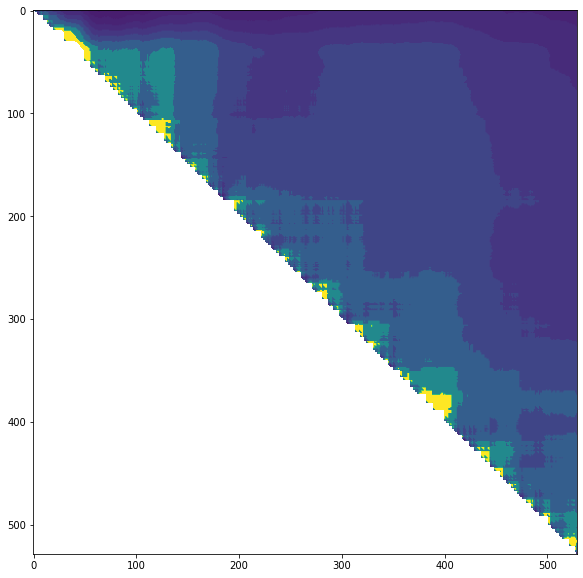

In [9]:
plt.imshow(1/wavg)

C:\Users\Laeeq\AppData\Local\Temp\ipykernel_5856\2088733990.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(np.sqrt(a)/wavg)
C:\Users\Laeeq\AppData\Local\Temp\ipykernel_5856\2088733990.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.sqrt(a)/wavg)


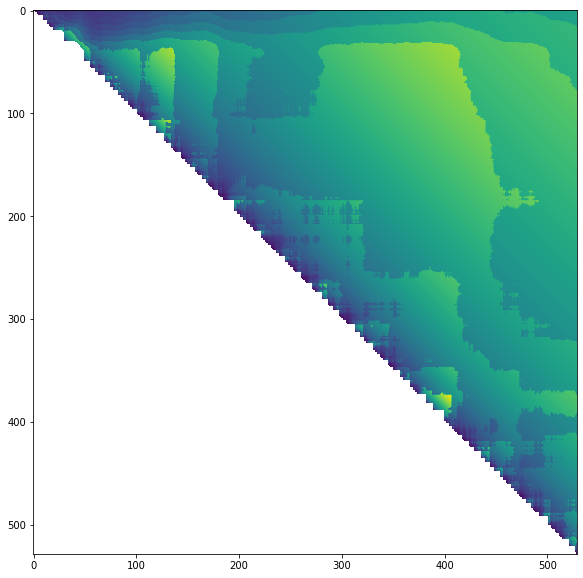

In [10]:
plt.imshow(np.sqrt(a)/wavg)

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

P01009 = pd.read_csv("data/AF-P01009-F1-model_v3.tsv", sep='\t')

# print(len(P01009))
# x_vars_P01009, _ = subsegment_variances(P01009.x)
# y_vars_P01009, _ = subsegment_variances(P01009.y)
# z_vars_P01009, _ = subsegment_variances(P01009.z)
# _, obs_means_P01009 = subsegment_variances(P01009.obs)

# # sq_obs_means = obs_means**0.5

# # generate pairwise distances
# N = len(P01009)
# dists_P01009 = np.zeros(shape=(N, N))
# for a in range(N):
#     for b in range(a, N):
#         dists_P01009[a][b] = (P01009.x[a]-P01009.x[b])**2 + (P01009.y[a]-P01009.y[b])**2 + (P01009.z[a]-P01009.z[b])**2



# domains = [(96, 318), (466,650)]



# # plot
# # fig, ax = plt.subplots(3, 4)
# fig, ax = plt.subplots(2, 3)

# ax[0][0].imshow(x_vars_P01009)
# ax[0][1].imshow(y_vars_P01009)
# ax[0][2].imshow(z_vars_P01009)
# # ax[0][3].imshow(obs_means)
# ax[1][0].imshow(x_vars_P01009 + y_vars_P01009 + z_vars_P01009)
# ax[1][1].imshow(dists_P01009)

# # ax[2][1].imshow(dists)




plt.show()

In [12]:

plt.hist(data['gamma'])

NameError: name 'data' is not defined

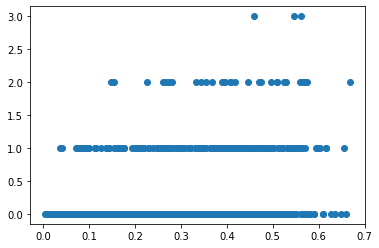

In [ ]:

plt.scatter(data.gamma*data.exp, data.obs)